# Connecting Workspace and Creating Experiment

In [35]:
import azureml.core
from azureml.core import Workspace
ws = Workspace.from_config()

print("Azure ML SDK Version: ", azureml.core.VERSION)
print(ws.name, ws.location, ws.resource_group, sep='\t')

Azure ML SDK Version:  1.7.0
msa-practice	australiaeast	msa-practice


In [48]:
from azureml.core import Experiment

exp_name = "clickbait"

experiment = Experiment(workspace=ws, name=exp_name)

# Load Data and Preprocessing

In [170]:
import pandas as pd
import numpy as np

df = pd.read_csv("clickbait_data.csv")
print(df.columns)
df.head(10)

Index(['headline', 'clickbait'], dtype='object')


,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1


In [171]:
# Preprocessing
from nltk.tokenize import word_tokenize

# Check for NA values - none found
print("Empty values:")
print(df.isnull().sum())

Empty values:
headline     0
clickbait    0
dtype: int64


In [172]:
def process(line):
    import re, string
    
    #To lowercase
    line = line.lower()
    
    # Remove punctuation
    line = line.translate(line.maketrans('','', string.punctuation))
    
    # Replace digits
    line = re.sub('\d+', 'num', line)
    
    return line

In [173]:
for (idx, (headline, _)) in df.iterrows():
    newline = process(headline)
    df.iloc[idx, 0] = newline

df.head(10)

,headline,clickbait
0,should i get bings,1
1,which tv female friend group do you belong in,1
2,the new star wars the force awakens trailer is...,1
3,this vine of new york on celebrity big brother...,1
4,a couple did a stunning photo shoot with their...,1
5,how to flirt with queer girls without making a...,1
6,num cute things to distract from your awkward ...,1
7,if disney princesses were from florida,1
8,whats a quote or lyric that best describes you...,1
9,natalie dormer and sam claflin play a game to ...,1


In [174]:
# Train-test split
from sklearn.model_selection import train_test_split

df_x = df.copy()
df_y = df_x.pop('clickbait')
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=66)

print(X_train[0:10])
print(X_test[0:10])

                                                headline
22460   australian airline qantas faces engineers strike
30647      us and russia to sign new arms control treaty
30720  num computex preview a decisive battle for it ...
7646       num unbelievably rude texts from your anxiety
2173   num perfect couple halloween costume ideas for...
2861           what its like having ppd as a black woman
28649  want to run  new york city marathon get out yo...
3712   num photos that are way too true when you have...
25025                       two tough mets but then what
14547  these two men had a perfect solution to their ...
                                                headline
10767                  num things that are metal as fuck
15930  num of the most embarrassing things people hav...
24306     want to get more work done try a bigger screen
2573   guys get nums boyband makeovers for their sign...
3949   this inkblot test will determine what you hate...
4072   num euphoric experiences

In [175]:
# Convert to numpy array
X_train = np.squeeze(X_train.values)
X_test = np.squeeze(X_test.values)
y_train = y_train.values
y_test = y_test.values

In [176]:
from keras.preprocessing.text import Tokenizer, one_hot
top_words = 1000
tokenizer = Tokenizer(num_words=top_words, filters='', oov_token=True)

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [177]:
print(X_train[0:10])
print("")
print(X_test[0:10])
print("")

[[96, 1, 1, 303, 1, 450], [20, 10, 374, 3, 109, 22, 1, 799, 1], [2, 1, 1, 8, 1, 815, 9, 44, 761, 10, 762, 105, 1], [2, 1, 1, 700, 21, 12, 936], [2, 194, 461, 123, 663, 710, 9, 7, 10, 12, 1], [24, 50, 55, 763, 1, 33, 8, 203, 147], [152, 3, 566, 22, 195, 218, 1, 76, 56, 12, 1], [2, 99, 15, 14, 102, 84, 269, 62, 7, 40, 8, 1], [86, 1, 518, 117, 865, 24], [42, 86, 235, 125, 8, 194, 1, 3, 47, 1, 1]]

[[2, 26, 15, 14, 1, 33, 925], [2, 6, 5, 57, 1, 26, 27, 40, 1, 18, 5, 1, 317], [152, 3, 76, 59, 253, 1, 145, 8, 1, 1], [369, 76, 148, 1, 1, 9, 47, 1, 1], [16, 1, 166, 19, 503, 24, 7, 584, 5, 57], [2, 1, 1, 9, 27, 25, 80, 1], [14, 7, 15, 1], [1, 989, 3, 776, 507, 171, 334, 10, 233, 311], [82, 1, 248, 1, 3, 898, 130, 1, 1], [1, 965, 3, 1, 17, 8, 1]]



In [182]:
from keras.preprocessing import sequence
title_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=title_length)
X_test = sequence.pad_sequences(X_test, maxlen=title_length)

# Training Model

In [186]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=title_length))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           32000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                51216     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 83,505
Trainable params: 83,505
Non-trainable params: 0
_________________________________________________________________
None


In [187]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25600 samples, validate on 6400 samples
Epoch 1/5
25600/25600 [==============================] - 2s 64us/step - loss: 0.3280 - accuracy: 0.8562 - val_loss: 0.1267 - val_accuracy: 0.9495
Epoch 2/5
25600/25600 [==============================] - 1s 23us/step - loss: 0.1033 - accuracy: 0.9630 - val_loss: 0.1019 - val_accuracy: 0.9594
Epoch 3/5
25600/25600 [==============================] - 1s 25us/step - loss: 0.0845 - accuracy: 0.9695 - val_loss: 0.1033 - val_accuracy: 0.9589
Epoch 4/5
25600/25600 [==============================] - 1s 24us/step - loss: 0.0764 - accuracy: 0.9725 - val_loss: 0.1038 - val_accuracy: 0.9595
Epoch 5/5
25600/25600 [==============================] - 1s 23us/step - loss: 0.0692 - accuracy: 0.9751 - val_loss: 0.1043 - val_accuracy: 0.9597


# Testing Model

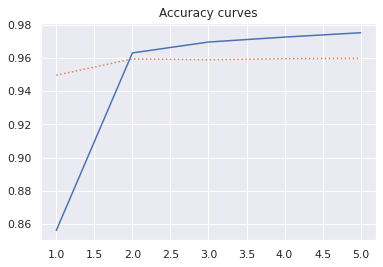

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val_acc, ':', label='Validation accuracy')
plt.title("Accuracy curves")
plt.show()

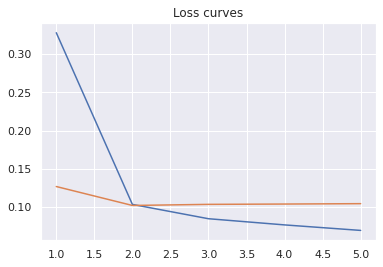

In [206]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, '-', label="Training loss")
plt.plot(epochs, val_loss, '-', label="Validation loss")
plt.title("Loss curves")
plt.show()

In [208]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 95.97%


# Making Predictions

In [286]:
def preprocess_line(text, tk):
    text = process(text)
    text = tokenizer.texts_to_sequences([text])
    print("Tokenised text: ", text)
    text = sequence.pad_sequences(text, maxlen=title_length)
    return text

def predict_input(text):
    prediction = model.predict(preprocess_line(text, tokenizer))
    output = "Yes" if (prediction > 0.5) else "No"
    print("Likelihood of title clickbait: {}%".format(prediction*100))
    print("Is it clickbait? {}".format(output))

In [288]:
text = input("Enter a title: ")
predict_input(text)

Enter a title:  MSA 2020 - AI & Advanced Analytics


Tokenised text:  [[1, 2, 1, 1, 1]]
Likelihood of title clickbait: [[24.272587]]%
Is it clickbait? No
